In [7]:
import pandas as pd
import glob

import os
from skimage import io, measure, morphology, color, filters, transform
import numpy as np

from matplotlib import pyplot as plt
import cv2
from tqdm.notebook import tqdm


import porespy as ps

from statsmodels.tsa.api import SimpleExpSmoothing
from scipy.signal import find_peaks
import more_itertools as mit

import urllib
# import torch
import numba

C:\anaconda3\envs\torch\lib\site-packages\openpnm\algorithms\_invasion_percolation.py:358: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _find_trapped_pores(inv_seq, indices, indptr, outlets):  # pragma: no cover


In [5]:
from matplotlib import pyplot as plt
import numpy as np

In [26]:
arr=np.load('length_mean.npy')

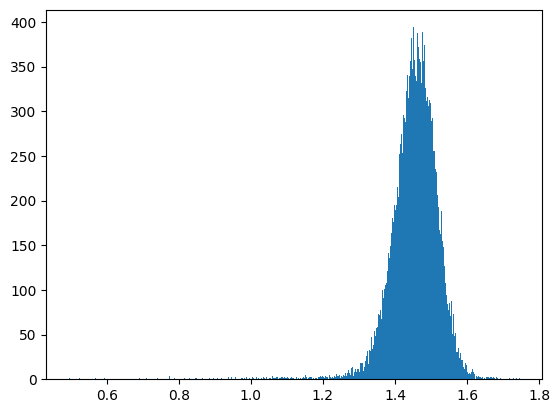

In [21]:
plt.hist(arr,bins=500)
# plt.xlim(0,200)
plt.show()

In [27]:
len(arr)

21301

In [23]:
len(arr)

21301

In [22]:
def rgb2smyk(bgr):
    bgrdash = bgr.astype(np.float32)/255.

    # Calculate K as (1 - whatever is biggest out of Rdash, Gdash, Bdash)
    K = 1 - np.max(bgrdash, axis=2)

    # Calculate C
    C = (1-bgrdash[...,2] - K)/(1-K)

    # Calculate M
    M = (1-bgrdash[...,1] - K)/(1-K)

    # Calculate Y
    Y = (1-bgrdash[...,0] - K)/(1-K)

    K*=255
    K=K.astype(np.uint8)

    C*=255
    C=C.astype(np.uint8)

    M*=255
    M=M.astype(np.uint8)

    Y*=255
    Y=Y.astype(np.uint8)

    return C,M,Y,K

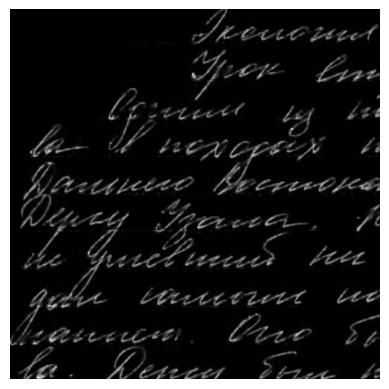

In [37]:
name='images/00200_163.jpg'
img=io.imread(name)


(C, M, Y, K) = rgb2smyk(img)

thresh, binaryImage = cv2.threshold(Y, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# thresh=threshold_otsu(Y)
thresh*=0.8
binaryImage=Y>thresh

# plt.imshow(img[:,:,2])
plt.imshow(Y[:600,:600], cmap='gray')
plt.axis('off')
plt.show()

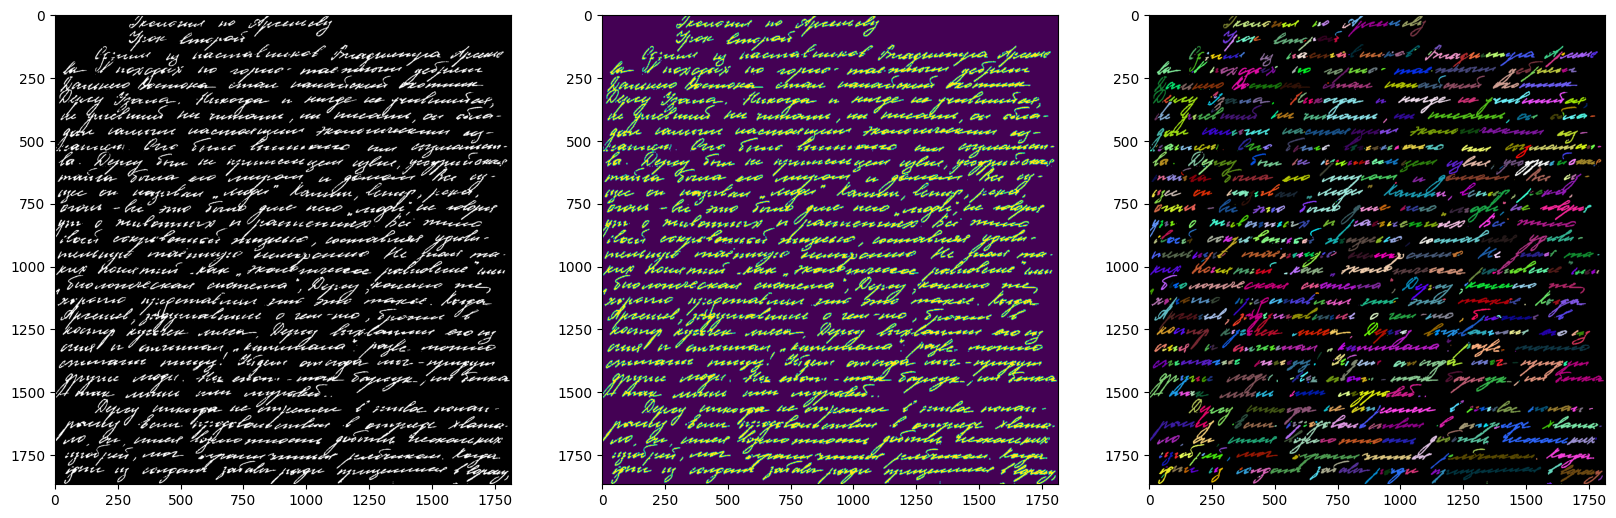

In [3]:
# name='62263_1.jpg'
name='00200_163.jpg'

img=io.imread(name)

# for k in range(N_lines):


(C, M, Y, K) = rgb2smyk(img)

thresh, binaryImage = cv2.threshold(Y, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# thresh=threshold_otsu(Y)
thresh*=0.8
binaryImage=Y>thresh

binaryImage=binaryImage*255
binaryImage=binaryImage.astype(np.uint8)

# binaryImage=morphology.binary_dilation(binaryImage, morphology.disk(1))

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, ksize=(1, 3))

dilated_image = cv2.dilate(binaryImage, kernel)

labeled_image = measure.label(dilated_image)

labels=np.sort(np.unique(labeled_image))
colors=[[np.random.uniform(0,255),np.random.uniform(0,255),np.random.uniform(0,255)] for label in labels]

colored_img=np.zeros((img.shape[0],img.shape[1],3))
for i,line in enumerate(labeled_image):
    for j,label in enumerate(line):
        if label!=0:
            colored_img[i,j]=colors[label]

colored_img=np.array(colored_img,dtype=np.uint8)

fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(20,10))
ax1.imshow(binaryImage, cmap='gray')
ax2.imshow(dilated_image)
ax3.imshow(colored_img)
plt.show()

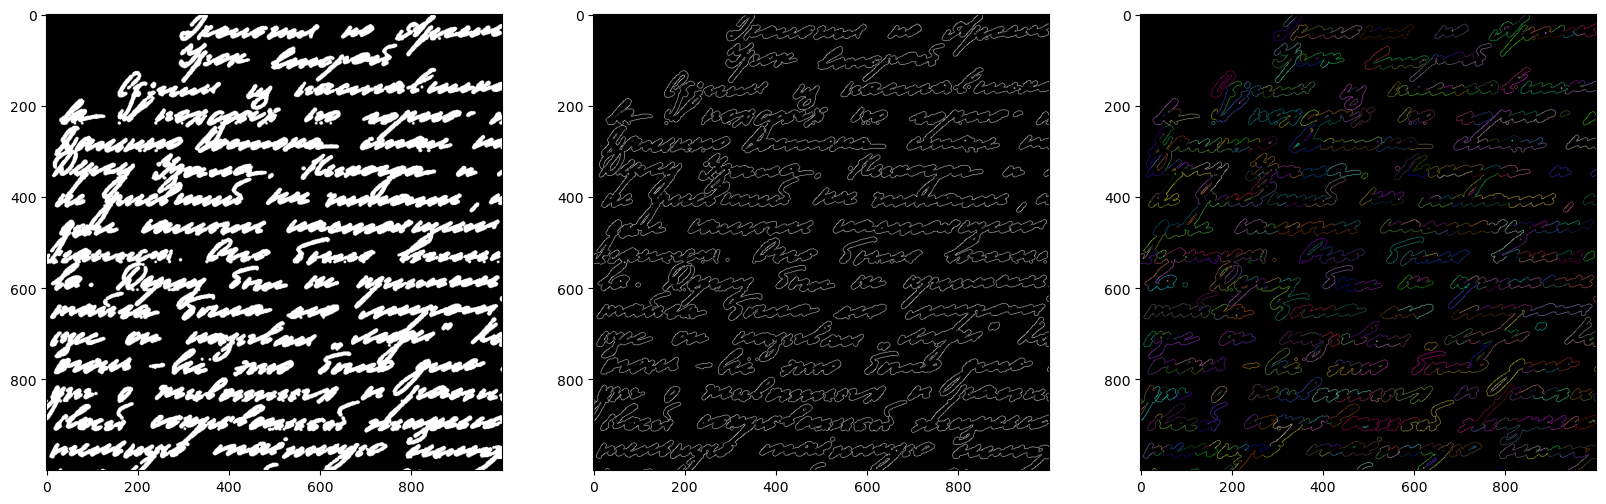

In [7]:
# name='62263_1.jpg'
name='00200_163.jpg'
img=io.imread(name)

(C, M, Y, K) = rgb2smyk(img)

thresh, binaryImage = cv2.threshold(Y, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

thresh*=0.8
binaryImage=Y>thresh

dilated_image=morphology.binary_dilation(binaryImage, morphology.disk(3))

dilated_image=dilated_image*255
dilated_image=dilated_image.astype(np.uint8)


edges = cv2.Canny(dilated_image, 0, 255, L2gradient=False)

# направление обхода контура по часовой стрелке
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
new_contours = []
for cnt in contours:
    new_contours.append(np.array(cnt).reshape((-1, 2)))

labeled_image = measure.label(edges)

labels=np.sort(np.unique(labeled_image))
colors=[[np.random.uniform(0,255),np.random.uniform(0,255),np.random.uniform(0,255)] for label in labels]

colored_img=np.zeros((img.shape[0],img.shape[1],3))
for i,line in enumerate(labeled_image):
    for j,label in enumerate(line):
        if label!=0:
            colored_img[i,j]=colors[label]

colored_img=np.array(colored_img,dtype=np.uint8)

fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(20,10))
ax1.imshow(dilated_image[:1000,:1000], cmap='gray')
ax2.imshow(edges[:1000,:1000], cmap='gray')
ax3.imshow(colored_img[:1000,:1000])
plt.show()

## Slope (in progress)

In [5]:
def chaincode(b, unwrap=False):
    '''
    Direction-to-code convention:
    --------------------------
    | deltax | deltay | code |
    |------------------------|    y
    |    0   |   +1   |   2  |    ^     3  2  1
    |    0   |   -1   |   6  |    |      \ | /
    |   -1   |   +1   |   3  |    |   4 -- P -- 0
    |   -1   |   -1   |   5  |    |      / | \ \
    |   +1   |   +1   |   1  |    |     5  6  7
    |   +1   |   -1   |   7  |    |
    |   -1   |    0   |   4  |    +-------------> x
    |   +1   |    0   |   0  |
    --------------------------
    '''
    delta = np.zeros(b.shape, dtype=int)
    delta[:-1, :] = b[1:, :] - b[:-1, :]
    delta[-1, :] = b[0, :] - b[-1, :]

    # check if boundary is 8-connected
    if ((np.abs(delta[:, 0]) > 1) + (np.abs(delta[:, 1]) > 1)).any():
        raise ValueError('Curve is not 8-connected.')

    # check if boundary is close, if so cut last element
    if (np.abs(delta[-1, :]) == 0).all():
        delta = delta[:-1, :]

    if ((np.abs(delta[:, 0]) == 0) * (np.abs(delta[:, 1]) == 0)).any():
        raise ValueError('Curve is degenerate.')

    idx = 3 * delta[:, 0] + delta[:, 1] + 4
    cm = np.array([5, 6, 7, 4, -1, 0, 3, 2, 1])
    cc = cm[idx]

    if unwrap:
        ucc = cc.copy()
        for i in range(1, ucc.shape[0]):
            ucc[i] += 8*np.round((ucc[i-1] - cc[i])/8.)
        return cc, b[0, :], ucc
    else:
        # return cc, b[0, :]
        return cc

In [6]:
def chain_plots(name):
    img=io.imread(name)

    (C, M, Y, K) = rgb2smyk(img)

    thresh, binaryImage = cv2.threshold(Y, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    thresh*=0.8
    binaryImage=Y>thresh

    dilated_image=morphology.binary_dilation(binaryImage, morphology.disk(3))

    dilated_image=dilated_image*255
    dilated_image=dilated_image.astype(np.uint8)


    edges = cv2.Canny(dilated_image, 0, 255, L2gradient=False)

    # направление обхода контура по часовой стрелке
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    new_contours = []

    for cnt in contours:
        if len(cnt)>5:
            new_contours.append(np.array(cnt).reshape((-1, 2)))

    freeman_chains=[]
    for cnt in new_contours:
        freeman_chains.extend(chaincode(cnt))

    freeman_pairs=np.zeros((8,8))
    for cnt in new_contours:
        chain=chaincode(cnt)
        freeman_pairs[chain[:-1],chain[1:]]+=1

    fig,(ax1,ax2,ax3,ax4,ax5,ax6)=plt.subplots(1,6,figsize=(20,3))
    ax1.hist(freeman_chains,bins=8)

    # fr=np.sort(freeman_pairs.flatten())
    fr=freeman_pairs.flatten()
    ax6.plot(fr)
    # fr2 = SimpleExpSmoothing(fr).fit(smoothing_level=0.3,optimized=False).fittedvalues
    ax2.plot(freeman_pairs[:,2])
    # ax2.plot(freeman_pairs[:,2],freeman_pairs[:,6])
    ax2.plot(freeman_pairs[:,6])
    ax3.plot(freeman_pairs[:,1])
    # ax3.plot(freeman_pairs[:,1],freeman_pairs[:,5])
    ax3.plot(freeman_pairs[:,5])
    ax4.plot(freeman_pairs[:,3])
    # ax4.plot(freeman_pairs[:,3],freeman_pairs[:,7])
    ax4.plot(freeman_pairs[:,7])
    ax5.plot(freeman_pairs[:,4])
    # ax5.plot(freeman_pairs[:,4],freeman_pairs[:,0])
    ax5.plot(freeman_pairs[:,0])


    plt.show()

In [ ]:
# name='62263_1.jpg'
# name='67205_2.jpg'
# name='00201_73.jpg'
# name='67205_3.jpg'
name='62325_1_12.jpg'
# name='00200_163.jpg'

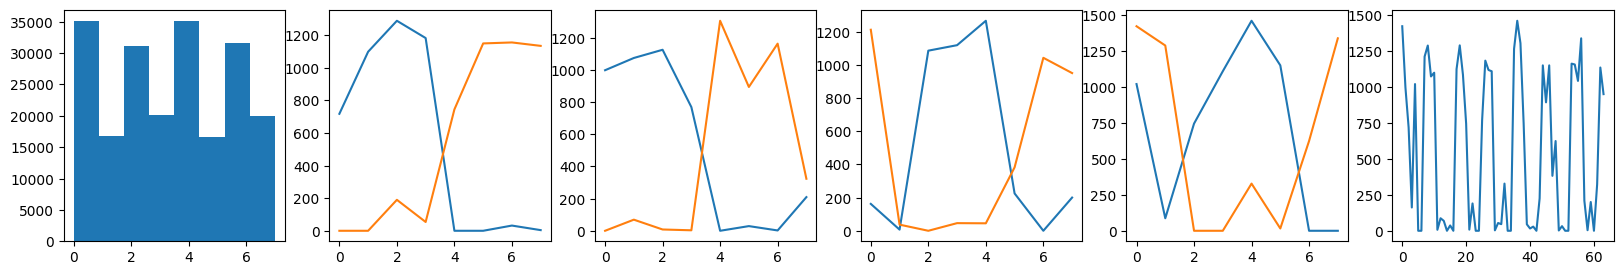

In [180]:
# '62325_1_12.jpg'
#  ровный

name='62325_1_12.jpg'

chain_plots(name)

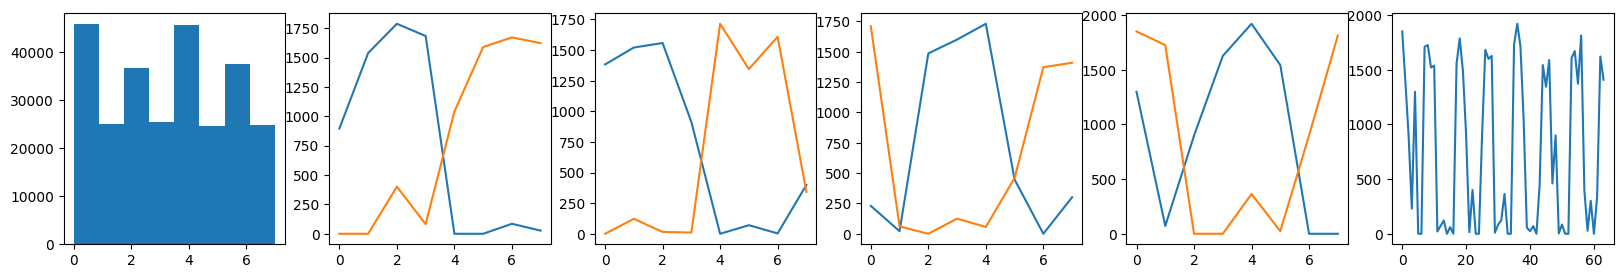

In [181]:
# ровный

name='00201_73.jpg'
chain_plots(name)

In [2]:
import numpy as np

from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage.draw import line as draw_line
from skimage import data

import matplotlib.pyplot as plt
from matplotlib import cm
from skimage import io

-1.5707963267948966
-1.5707963267948966
-1.5707963267948966
-1.5707963267948966
1.562069680534925
-1.5707963267948966
-1.5707963267948966
-1.5707963267948966
-1.5707963267948966
-1.5707963267948966
-1.5707963267948966
-1.5707963267948966
-1.5707963267948966
-1.5707963267948966
-1.5707963267948966
-1.5707963267948966
0.7853981633974483
-1.5707963267948966
-1.5707963267948966
-1.5707963267948966
1.562069680534925
-1.562069680534925
1.562069680534925
1.562069680534925
-1.5707963267948966
-1.5707963267948966
-1.5707963267948966
1.562069680534925
-1.562069680534925
0.7853981633974483
0.7853981633974483
-1.562069680534925
-1.5707963267948966
0.7853981633974483
-1.562069680534925
0.7853981633974483
-1.562069680534925
-0.7853981633974483
0.7853981633974483
0.7853981633974483
0.7853981633974483
-0.7853981633974483
0.7853981633974483
0.7853981633974483
0.7853981633974483
0.7853981633974483
-0.7853981633974483
0.7853981633974483
0.7853981633974483
0.45378560551852587
0.6632251157578453
0.78539816

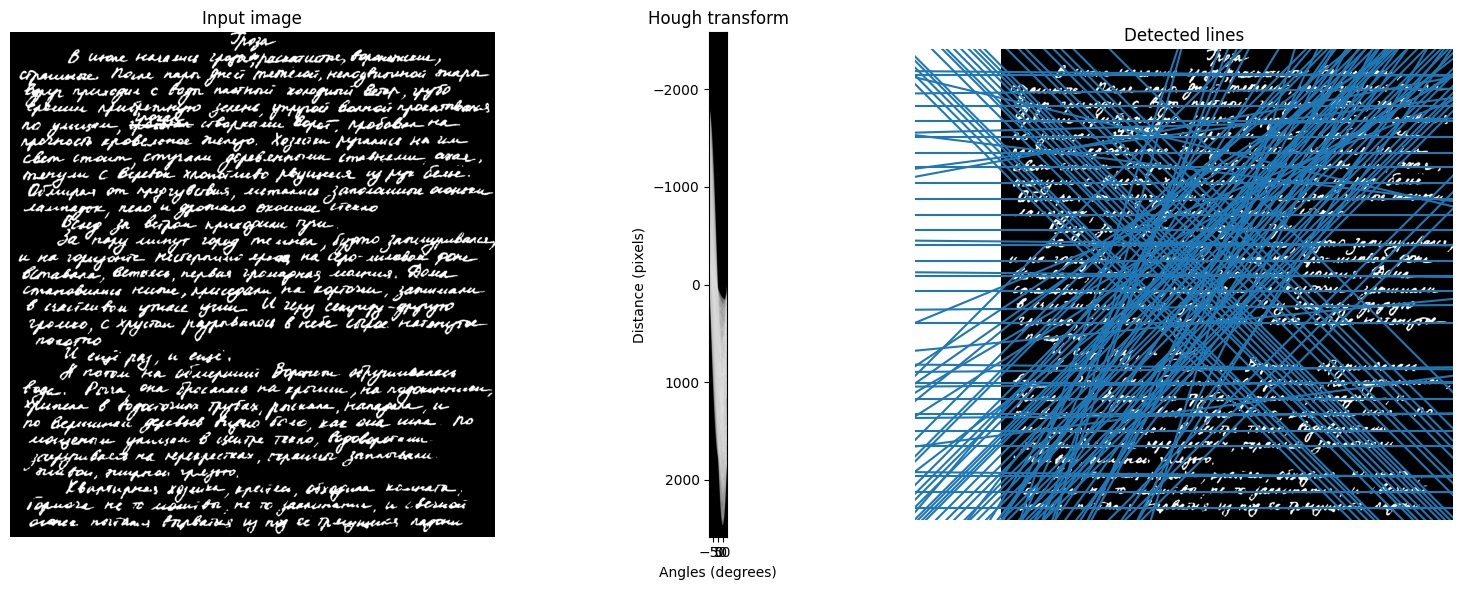

In [20]:
# Constructing test image
image=io.imread('images/62263_1.jpg')

(C, M, Y, K) = rgb2smyk(image)

thresh, binaryImage = cv2.threshold(Y, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

thresh*=0.8
image=Y>thresh

# Classic straight-line Hough transform
# Set a precision of 0.5 degree.
tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
h, theta, d = hough_line(image, theta=tested_angles)

# Generating figure 1
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
ax = axes.ravel()

ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Input image')
ax[0].set_axis_off()

angle_step = 0.5 * np.diff(theta).mean()
d_step = 0.5 * np.diff(d).mean()
bounds = [np.rad2deg(theta[0] - angle_step),
          np.rad2deg(theta[-1] + angle_step),
          d[-1] + d_step, d[0] - d_step]
ax[1].imshow(np.log(1 + h), extent=bounds, cmap=cm.gray, aspect=1 / 1.5)
ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')
ax[1].axis('image')

ax[2].imshow(image, cmap=cm.gray)
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')

for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    print(angle)
    # if angle<1 and angle>0:
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    ax[2].axline((x0, y0), slope=np.tan(angle + np.pi/2))

plt.tight_layout()
plt.show()

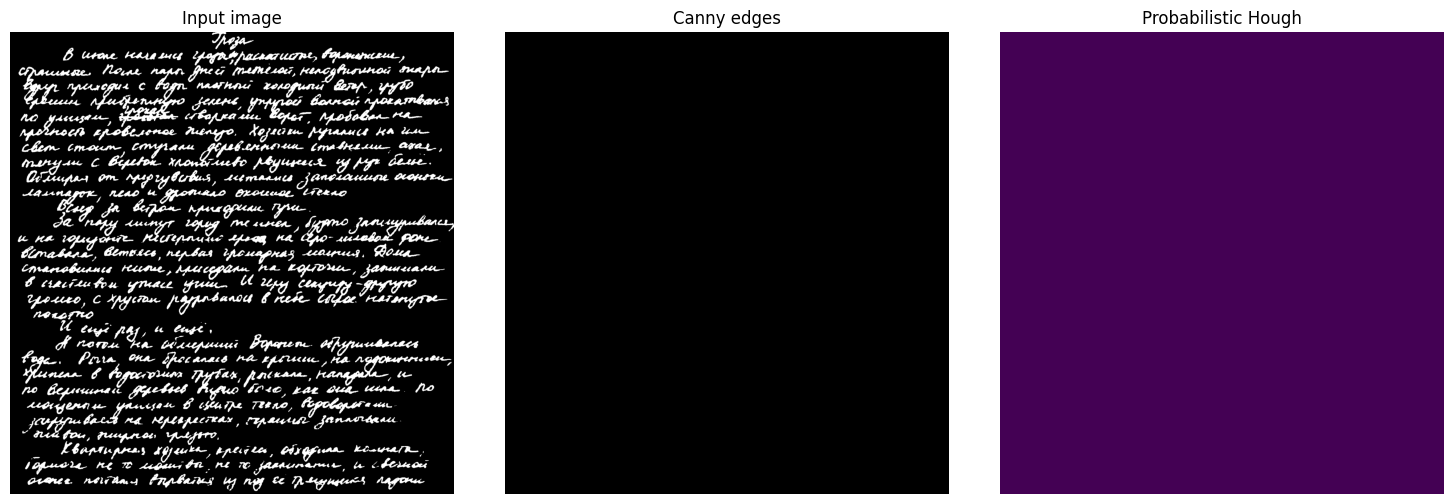

In [21]:
from skimage.transform import probabilistic_hough_line

# Line finding using the Probabilistic Hough Transform

image=io.imread('images/62263_1.jpg')

(C, M, Y, K) = rgb2smyk(image)

thresh, binaryImage = cv2.threshold(Y, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

thresh*=0.8
image=Y>thresh

edges = canny(image, 2, 1, 25)
lines = probabilistic_hough_line(edges, threshold=10, line_length=5,
                                 line_gap=3)

# Generating figure 2
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Input image')

ax[1].imshow(edges, cmap=cm.gray)
ax[1].set_title('Canny edges')

ax[2].imshow(edges * 0)
for line in lines:
    p0, p1 = line
    ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[2].set_xlim((0, image.shape[1]))
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_title('Probabilistic Hough')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()